# Pricing American style options using binomial tree models

First of all, let us import all the necessary packages. We will also import some function from the course used to deal with options data obtained via yfinance. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import datetime as datetime
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox

#Lecture functions, need for volatility
%run functions.py

sns.set_style('darkgrid')

The following procedures were also used in the lectures to find time to expiration and approximate spot prices.

In [2]:
from dateutil import parser
from dateutil.tz import tzutc

def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')

We are going to focus on the American style options -- they differ from European style options in the sense that they can be exercised at **any** point before the expiration time $T$. 
Because of that, we cannot use the Black-Scholes model to obtain the closed form solution for the call and put pricing.

The key idea consists of leveraging this differences and try to come up with a discrete model that simulates the act of exercising the option at different time points.

We are going to start by providing the Cox-Ross-Rubinstein model, as per [1].

[1] Cox, J. C., Ross, S. A., Rubinstein, M., “Option Pricing: A Simplified Approach”, Journal of Financial Economics (1979)

I used the respective Wikipedia article (https://en.wikipedia.org/wiki/Binomial_options_pricing_model) to implement the model. The model operates under the standard no-arbitrage and risk-free interest conditions, as in Black-Scholes.

In [3]:
def american_option_price_call_CRR(S0, K, T, r, sigma, n):
    """
    Computes the price of an American option using the CRR binomial model.

    Args:
        S0 (float): Initial stock price.
        K (float): Strike price.
        T (float): Time to maturity in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        n (int): Number of steps in the binomial tree.
    Returns:
        float: The calculated American option price.
    """

    # Calculate time step and up/down factors
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    # Calculate risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option values at maturity
    option_values = np.zeros(n + 1)
    
    # Calculate stock prices at maturity
    stock_prices = S0 * (u ** np.arange(n, -1, -1)) * (d ** np.arange(0, n + 1, 1))

    # Calculate intrinsic values at maturity
    option_values = np.maximum(0, stock_prices - K)

    # Work backwards through the tree
    for i in range(n - 1, -1, -1):
        stock_prices = S0 * (u ** np.arange(i, -1, -1)) * (d ** np.arange(0, i + 1, 1))
        # Calculate continuation value (expected value discounted back)
        continuation_values = np.exp(-r * dt) * (p * option_values[1:i + 2] + (1 - p) * option_values[0:i + 1])
        
        # Calculate intrinsic value for early exercise
        intrinsic_values = np.maximum(0, stock_prices - K)
        
        # American option value is the maximum of continuation or early exercise
        option_values = np.maximum(continuation_values, intrinsic_values)

    return option_values[0]

def american_option_price_put_CRR(S0, K, T, r, sigma, n):
    """
    Computes the price of an American option using the CRR binomial model.

    Args:
        S0 (float): Initial stock price.
        K (float): Strike price.
        T (float): Time to maturity in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        n (int): Number of steps in the binomial tree.
    Returns:
        float: The calculated American option price.
    """

    # Calculate time step and up/down factors
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    # Calculate risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option values at maturity
    option_values = np.zeros(n + 1)
    
    # Calculate stock prices at maturity
    stock_prices = S0 * (u ** np.arange(n, -1, -1)) * (d **np.arange(0, n + 1, 1))

    # Calculate intrinsic values at maturity
    option_values = np.maximum(0, K - stock_prices)

    # Work backwards through the tree
    for i in range(n - 1, -1, -1):
        stock_prices = S0 * (u ** np.arange(i, -1, -1)) * (d ** np.arange(0, i + 1, 1))
        # Calculate continuation value (expected value discounted back)
        continuation_values = np.exp(-r * dt) * (p * option_values[1:i + 2] + (1 - p) * option_values[0:i + 1])
        
        # Calculate intrinsic value for early exercise
        intrinsic_values = np.maximum(0, K - stock_prices)
        
        # American option value is the maximum of continuation or early exercise
        option_values = np.maximum(continuation_values, intrinsic_values)

    return option_values[0]

The following model, described by Y. Tian in [2], is a modification of the binomial tree model with an improved convergence rate. 

[2] Tian, Y.“. (1999), A flexible binomial option pricing model. J. Fut. Mark., 19: 817-843. 

In [4]:
def tian_american_binomial_call(S0, K, T, r, sigma, n):
    """
    Prices an American-style option using the Tian (1993) binomial model.

    Parameters:
    - S0: float, Current stock price
    - K: float, Strike price
    - T: float, Time to maturity (in years)
    - r: float, Risk-free interest rate (annualized, continuous)
    - sigma: float, Volatility (annualized)
    - n: int, Number of time steps in the binomial tree
    - option_type: str, 'call' or 'put'

    Returns:
    - float: The estimated price of the American option
    """

    dt = T / n  # Time step duration
    
    # Calculate Tian model factors
    a = np.exp(r * dt)
    nu = np.exp(sigma**2 * dt)
    
    # Term inside the square root
    sqrt_inner = nu**2 + 2*nu - 3
    # Handle edge case where sigma or dt is 0 (nu=1)
    sqrt_inner = max(0, sqrt_inner) 
    sqrt_term = np.sqrt(sqrt_inner)

    # Up and down move factors
    u = 0.5 * a * nu * (nu + 1 + sqrt_term)
    d = 0.5 * a * nu * (nu + 1 - sqrt_term)

    # Risk-neutral probabilities
    # Handle divide-by-zero if sigma=0 (u=d)
    if abs(u - d) < 1e-10:
        # If sigma is 0, the price is deterministic.
        S_T = S0 * np.exp(r * T)
        return max(0, S_T - K) * np.exp(-r * T)

    p = (a - d) / (u - d)  # Probability of an up move
    q = 1.0 - p          # Probability of a down move

    # Discount factor for one time step
    disc = np.exp(-r * dt)

    # --- 3. Initialize Option Values at Maturity (Time T) ---
    
    # We only need to store one "slice" of the tree at a time.
    # V will hold the N+1 option values at maturity.
    V = np.zeros(n + 1)

    # Calculate stock prices at maturity (N+1 nodes)
    # S_T(j) = S0 * u^j * d^(N-j)  for j = 0, 1, ..., N
    j_values = np.arange(0, n + 1)
    S_T_nodes = S0 * (u**j_values) * (d**(n - j_values))

    # Calculate option payoffs at maturity
    V = np.maximum(0, S_T_nodes - K)
    
    # Loop backward from time step N-1 down to 0
    for i in range(n - 1, -1, -1):
        # At step i, there are i+1 nodes.
        # V currently holds i+2 values from step i+1.
        
        # 1. Calculate the Continuation Value (European value)
        # V[1:] are the (i+1) "up" nodes from step i+1
        # V[:-1] are the (i+1) "down" nodes from step i+1
        V_cont = disc * (p * V[1:] + q * V[:-1])
        
        # 2. Calculate the Intrinsic (Early Exercise) Value
        # We need the stock prices at time step i
        j_values = np.arange(0, i + 1) # i+1 nodes at step i
        S_i_nodes = S0 * (u**j_values) * (d**(i - j_values))
        
        V_ex = np.maximum(0, S_i_nodes - K)

        # 3. American Value: Max of continuation or exercise
        # V is "resized" to hold the i+1 values for the current step i
        V = np.maximum(V_cont, V_ex)
    
    # After the loop, V has only one element (V[0]), which is the price at t=0
    return V[0]

def tian_american_binomial_put(S0, K, T, r, sigma, n):
    """
    Prices an American-style option using the Tian (1993) binomial model.

    Parameters:
    - S0: float, Current stock price
    - K: float, Strike price
    - T: float, Time to maturity (in years)
    - r: float, Risk-free interest rate (annualized, continuous)
    - sigma: float, Volatility (annualized)
    - n: int, Number of time steps in the binomial tree
    - option_type: str, 'call' or 'put'

    Returns:
    - float: The estimated price of the American option
    """
    dt = T / n  # Time step duration
    
    # Calculate Tian model factors
    a = np.exp(r * dt)
    nu = np.exp(sigma**2 * dt)
    
    # Term inside the square root
    sqrt_inner = nu**2 + 2*nu - 3
    # Handle edge case where sigma or dt is 0 (nu=1)
    sqrt_inner = max(0, sqrt_inner) 
    sqrt_term = np.sqrt(sqrt_inner)

    # Up and down move factors
    u = 0.5 * a * nu * (nu + 1 + sqrt_term)
    d = 0.5 * a * nu * (nu + 1 - sqrt_term)

    # Risk-neutral probabilities
    # Handle divide-by-zero if sigma=0 (u=d)
    if abs(u - d) < 1e-10:
        # If sigma is 0, the price is deterministic.
        S_T = S0 * np.exp(r * T)
        payoff = max(0, K - S_T)
        payoff = max(payoff * np.exp(-r * T), max(0, K - S0))
        return payoff

    p = (a - d) / (u - d)  # Probability of an up move
    q = 1.0 - p          # Probability of a down move

    # Discount factor for one time step
    disc = np.exp(-r * dt)

    
    # We only need to store one "slice" of the tree at a time.
    # V will hold the N+1 option values at maturity.
    V = np.zeros(n + 1)

    # Calculate stock prices at maturity (N+1 nodes)
    # S_T(j) = S0 * u^j * d^(N-j)  for j = 0, 1, ..., N
    j_values = np.arange(0, n + 1)
    S_T_nodes = S0 * (u**j_values) * (d**(n - j_values))

    # Calculate option payoffs at maturity
    V = np.maximum(0, K - S_T_nodes)
    
    # Loop backward from time step N-1 down to 0
    for i in range(n - 1, -1, -1):
        # At step i, there are i+1 nodes.
        # V currently holds i+2 values from step i+1.
        
        # 1. Calculate the Continuation Value (European value)
        # V[1:] are the (i+1) "up" nodes from step i+1
        # V[:-1] are the (i+1) "down" nodes from step i+1
        V_cont = disc * (p * V[1:] + q * V[:-1])
        
        # 2. Calculate the Intrinsic (Early Exercise) Value
        # We need the stock prices at time step i
        j_values = np.arange(0, i + 1) # i+1 nodes at step i
        S_i_nodes = S0 * (u**j_values) * (d**(i - j_values))
        
        V_ex = np.maximum(0, K - S_i_nodes)
            
        # 3. American Value: Max of continuation or exercise
        # V is "resized" to hold the i+1 values for the current step i
        V = np.maximum(V_cont, V_ex)
    # After the loop, V has only one element (V[0]), which is the price at t=0
    return V[0]

Finally, we are going to provide the implementation of the Jarrow-Rudd model, referred to as the equal probability model.

In [5]:
def jarrow_rudd_american_binomial_call(S0, K, T, r, sigma, N):
    """
    Prices an American-style option using the Jarrow-Rudd (1983) binomial model.

    Parameters:
    - S0: float, Current stock price
    - K: float, Strike price
    - T: float, Time to maturity (in years)
    - r: float, Risk-free interest rate (annualized, continuous)
    - sigma: float, Volatility (annualized)
    - N: int, Number of time steps in the binomial tree
    - option_type: str, 'call' or 'put'

    Returns:
    - float: The estimated price of the American option
    """

    dt = T / N 
    
    # Calculate Jarrow-Rudd model parameters
    # (Also known as the lognormal model)
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    u = np.exp(drift + diffusion)
    d = np.exp(drift - diffusion)
    
    # Jarrow-Rudd model sets p = 0.5 by construction
    p = 0.5
    q = 0.5 # 1.0 - p

    # Discount factor for one time step
    disc = np.exp(-r * dt)

    # V will hold the N+1 option values at maturity.
    V = np.zeros(N + 1)

    # Calculate stock prices at maturity (N+1 nodes)
    # S_T(j) = S0 * u^j * d^(N-j)  for j = 0, 1, ..., N
    j_values = np.arange(0, N + 1)
    S_T_nodes = S0 * (u**j_values) * (d**(N - j_values))

    # Calculate option payoffs at maturity
    V = np.maximum(0, S_T_nodes - K)

    # Loop backward from time step N-1 down to 0
    for i in range(N - 1, -1, -1):
        # At step i, there are i+1 nodes.
        # V currently holds i+2 values from step i+1.
        
        # 1. Calculate the Continuation Value (European value)
        # V[1:] are the (i+1) "up" nodes from step i+1
        # V[:-1] are the (i+1) "down" nodes from step i+1
        V_cont = disc * (p * V[1:] + q * V[:-1])
        
        # 2. Calculate the Intrinsic (Early Exercise) Value
        # We need the stock prices at time step i
        j_values = np.arange(0, i + 1) # i+1 nodes at step i
        S_i_nodes = S0 * (u**j_values) * (d**(i - j_values))
        
        V_ex = np.maximum(0, S_i_nodes - K)
            
        # 3. American Value: Max of continuation or exercise
        # V is "resized" to hold the i+1 values for the current step i
        V = np.maximum(V_cont, V_ex)
        
    # After the loop, V has only one element (V[0]), which is the price at t=0
    return V[0]

def jarrow_rudd_american_binomial_put(S0, K, T, r, sigma, N):
    """
    Prices an American-style option using the Jarrow-Rudd (1983) binomial model.

    Parameters:
    - S0: float, Current stock price
    - K: float, Strike price
    - T: float, Time to maturity (in years)
    - r: float, Risk-free interest rate (annualized, continuous)
    - sigma: float, Volatility (annualized)
    - N: int, Number of time steps in the binomial tree
    - option_type: str, 'call' or 'put'

    Returns:
    - float: The estimated price of the American option
    """
    dt = T / N  # Time step duration
    
    # Calculate Jarrow-Rudd model parameters
    # (Also known as the lognormal model)
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    u = np.exp(drift + diffusion)
    d = np.exp(drift - diffusion)
    
    # Jarrow-Rudd model sets p = 0.5 by construction
    p = 0.5
    q = 0.5 # 1.0 - p

    # Discount factor for one time step
    disc = np.exp(-r * dt)

    
    # V will hold the N+1 option values at maturity.
    V = np.zeros(N + 1)

    # Calculate stock prices at maturity (N+1 nodes)
    # S_T(j) = S0 * u^j * d^(N-j)  for j = 0, 1, ..., N
    j_values = np.arange(0, N + 1)
    S_T_nodes = S0 * (u**j_values) * (d**(N - j_values))

    # Calculate option payoffs at maturity
    V = np.maximum(0, K - S_T_nodes)

    
    # Loop backward from time step N-1 down to 0
    for i in range(N - 1, -1, -1):
        # At step i, there are i+1 nodes.
        # V currently holds i+2 values from step i+1.
        
        # 1. Calculate the Continuation Value (European value)
        # V[1:] are the (i+1) "up" nodes from step i+1
        # V[:-1] are the (i+1) "down" nodes from step i+1
        V_cont = disc * (p * V[1:] + q * V[:-1])
        
        # 2. Calculate the Intrinsic (Early Exercise) Value
        # We need the stock prices at time step i
        j_values = np.arange(0, i + 1) # i+1 nodes at step i
        S_i_nodes = S0 * (u**j_values) * (d**(i - j_values))
        
        V_ex = np.maximum(0, K - S_i_nodes)
            
        # 3. American Value: Max of continuation or exercise
        # V is "resized" to hold the i+1 values for the current step i
        V = np.maximum(V_cont, V_ex)
        
    # After the loop, V has only one element (V[0]), which is the price at t=0
    return V[0]

In [27]:
# Get the options data and run the appropriate model for call options on a given day

def get_options_run_model(ticker_name="AAPL", start='2025-11-01', end='2025-11-05', interval='1m', r=0.03, expiration_date='2025-11-07', model="CRR", option_type="call"):
    """
    Fetches the option data for the given ticker and given dates, outputs the graph which shows 
    the relation between the yfinance prices and modeled prices using one of the binomial tree models implemented.
    ticker_name: Stock ticker
    start: Starting date
    end: Final date
    interval: The interval between distinct stock prices
    r: Interest rate
    expiration_date: Expiration date
    model = Can be 'CRR' or 'JR' or 'Tian'
    option type: 'call' or 'put'
    """
    ticker = yf.Ticker(ticker_name)
    stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
    
    expirations = ticker.options
    
    
    #Create array to store options data
    option_data = []
    
    for date in expirations:
        chain = ticker.option_chain(date)
    
        # Add expiration and label
        calls = chain.calls.copy()
        calls['expiration'] = date
        calls['option_type'] = 'call'
    
        puts = chain.puts.copy()
        puts['expiration'] = date
        puts['option_type'] = 'put'
    
        option_data.append(calls)
        option_data.append(puts)
    
    # Combine all into one DataFrame and delete implied volatility column since we'll recalculate.
    options_data = pd.concat(option_data, ignore_index=True)
    
    #Delete any options that were traded in the interval of historical stock values obtained
    start_date = stock_data.index[0]
    options_data = options_data[options_data['lastTradeDate']>=start_date]
    
    
    #Insert column of time to expiration in years of the option contract measured from time of last trade
    options_data['time_to_expiration'] = options_data.apply(
    lambda row: find_tte_yf_options(expiration_date = row['expiration'],
                                   last_trade_date = row['lastTradeDate']),
        axis = 1
    )
    
    
    #Add in column of the spot price of stock when the option trade occured.
    options_data['spot_price'] = options_data.apply(
        lambda row: yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
        axis=1
    )
    options_data = options_data.dropna()
    
    
    
    
    
    #Create data frames that keeps relevant information and separate calls from puts.
    options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                                 'expiration', 'option_type','time_to_expiration', 'spot_price', 'impliedVolatility']]
    options_data_calls = options_data[(options_data['option_type'] == 'call')].copy()
    options_data_puts = options_data[(options_data['option_type'] == 'put')].copy()
    

    #Remove rows with undefined values
    options_data_calls = options_data_calls.dropna()
    options_data_puts = options_data_puts.dropna()

    #Store the prices of options from yfinance data
    true_call_options_prices = options_data_calls[options_data_calls['expiration'] == expiration_date]['lastPrice']
    true_put_options_prices = options_data_puts[options_data_puts['expiration'] == expiration_date]['lastPrice']

    #Depending on the choice of the binomial tree model and type of options, implement pricing 
    #and plot the yfinance prices against the modeled ones
    #Unlike in lectures, we just take the impliedVolatility value from the data.
    if model == "CRR":
        if option_type=='call':
            crr_call_options_prices = options_data_calls[options_data_calls['expiration'] == expiration_date].apply(
                lambda row: american_option_price_call_CRR(
                    S0 = row['spot_price'],
                    K = row["strike"],
                    T = row["time_to_expiration"],
                    r = r,
                    sigma = row["impliedVolatility"],
                    n=100
                ),
                axis=1
            )
            plt.figure(figsize = (12,8))
            plt.plot(true_call_options_prices, label = 'True call prices')
            plt.plot(crr_call_options_prices, label = 'CRR modeled call prices')
            plt.legend()
        
        elif option_type=='put':
            crr_put_options_prices = options_data_puts[options_data_puts['expiration'] == expiration_date].apply(
                lambda row: american_option_price_put_CRR(
                    S0 = row['spot_price'],
                    K = row["strike"],
                    T = row["time_to_expiration"],
                    r = r,
                    sigma = row["impliedVolatility"],
                    n=100
                ),
                axis=1
            )
            plt.figure(figsize = (12,8))
            plt.plot(true_put_options_prices, label = 'True put prices')
            plt.plot(crr_put_options_prices, label = 'CRR modeled put prices')
            plt.legend()
    elif model == 'Tian':
        if option_type=='call':
            tian_call_options_prices = options_data_calls[options_data_calls['expiration'] == expiration_date].apply(
                lambda row: tian_american_binomial_call(
                    S0 = row['spot_price'],
                    K = row["strike"],
                    T = row["time_to_expiration"],
                    r = r,
                    sigma = row["impliedVolatility"],
                    n=100
                ),
                axis=1
            )
            plt.figure(figsize = (12,8))
            plt.plot(true_call_options_prices, label = 'True call prices')
            plt.plot(tian_call_options_prices, label = 'Tian modeled call prices')
            plt.legend()
        elif option_type=='put':
            tian_put_options_prices = options_data_puts[options_data_puts['expiration'] == expiration_date].apply(
                lambda row: tian_american_binomial_put(
                    S0 = row['spot_price'],
                    K = row["strike"],
                    T = row["time_to_expiration"],
                    r = r,
                    sigma = row["impliedVolatility"],
                    n=100
                ),
                axis=1
            )
            plt.figure(figsize = (12,8))
            plt.plot(true_put_options_prices, label = 'True put prices')
            plt.plot(tian_put_options_prices, label = 'Tian modeled put prices')
            plt.legend()
    elif model == 'JR':
        if option_type=='call':
            JR_call_options_prices = options_data_calls[options_data_calls['expiration'] == expiration_date].apply(
                lambda row: jarrow_rudd_american_binomial_call(
                    S0 = row['spot_price'],
                    K = row["strike"],
                    T = row["time_to_expiration"],
                    r = r,
                    sigma = row["impliedVolatility"],
                    N=100
                ),
                axis=1
            )
            plt.figure(figsize = (12,8))
            plt.plot(true_call_options_prices, label = 'True call prices')
            plt.plot(JR_call_options_prices, label = 'Jarrow-Rudd call prices')
            plt.legend()
        elif option_type=='put':
            JR_put_options_prices = options_data_puts[options_data_puts['expiration'] == expiration_date].apply(
                lambda row: jarrow_rudd_american_binomial_put(
                    S0 = row['spot_price'],
                    K = row["strike"],
                    T = row["time_to_expiration"],
                    r = r,
                    sigma = row["impliedVolatility"],
                    n=100
                ),
                axis=1
            )
            plt.figure(figsize = (12,8))
            plt.plot(true_put_options_prices, label = 'True put prices')
            plt.plot(JR_put_options_prices, label = 'JR modeled put prices')
            plt.legend()
        

Let us consider a ticker (like AAPL or SPY) to demonstrate the precision of different models.

/tmp/ipykernel_3534/1254214214.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3534/1254214214.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3534/1254214214.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed


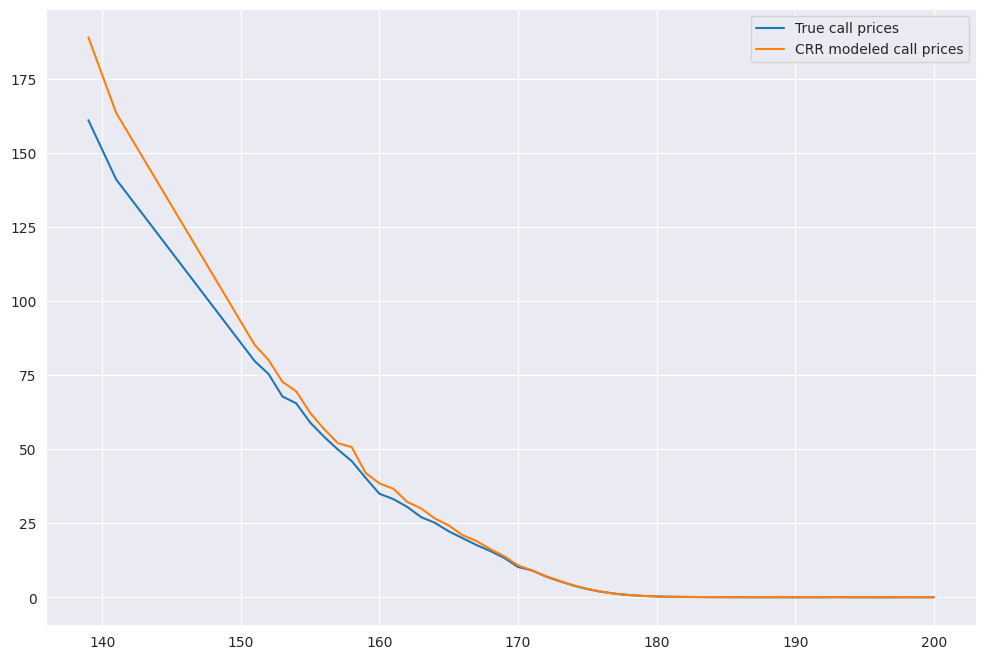

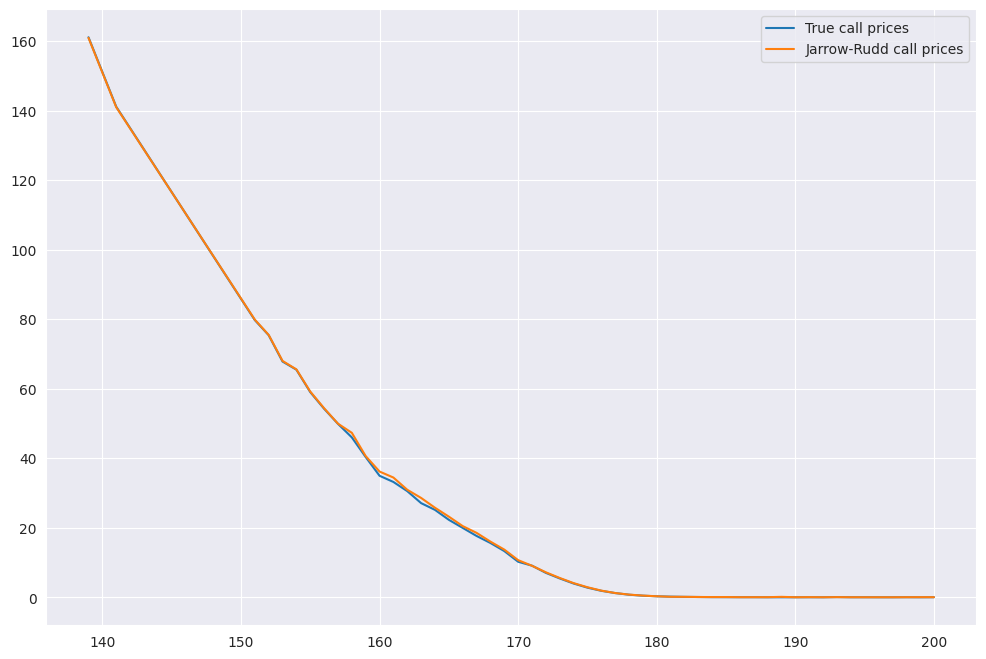

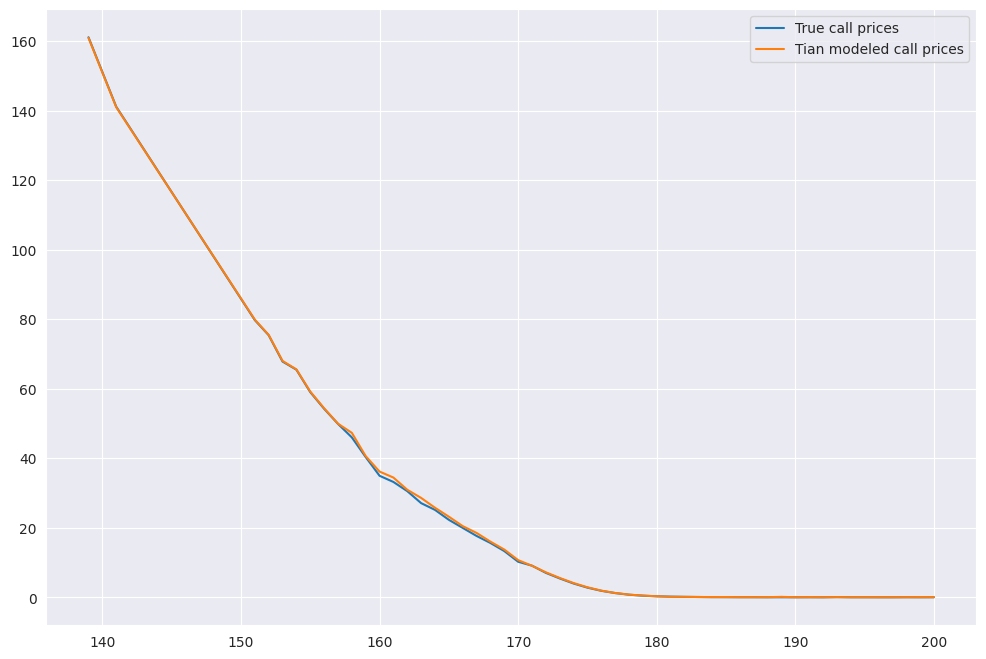

In [28]:
get_options_run_model(ticker_name="AAPL", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-11-14', model="CRR", option_type="call")
get_options_run_model(ticker_name="AAPL", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-11-14', model="JR", option_type="call")
get_options_run_model(ticker_name="AAPL", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-11-14', model="Tian", option_type="call")

/tmp/ipykernel_3534/1254214214.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3534/1254214214.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3534/1254214214.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed


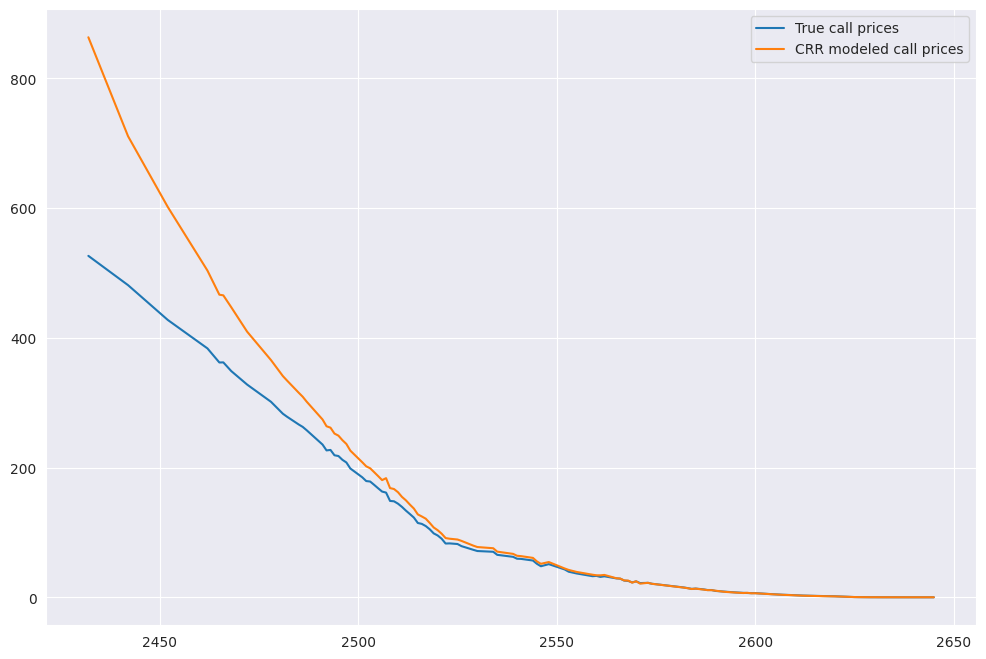

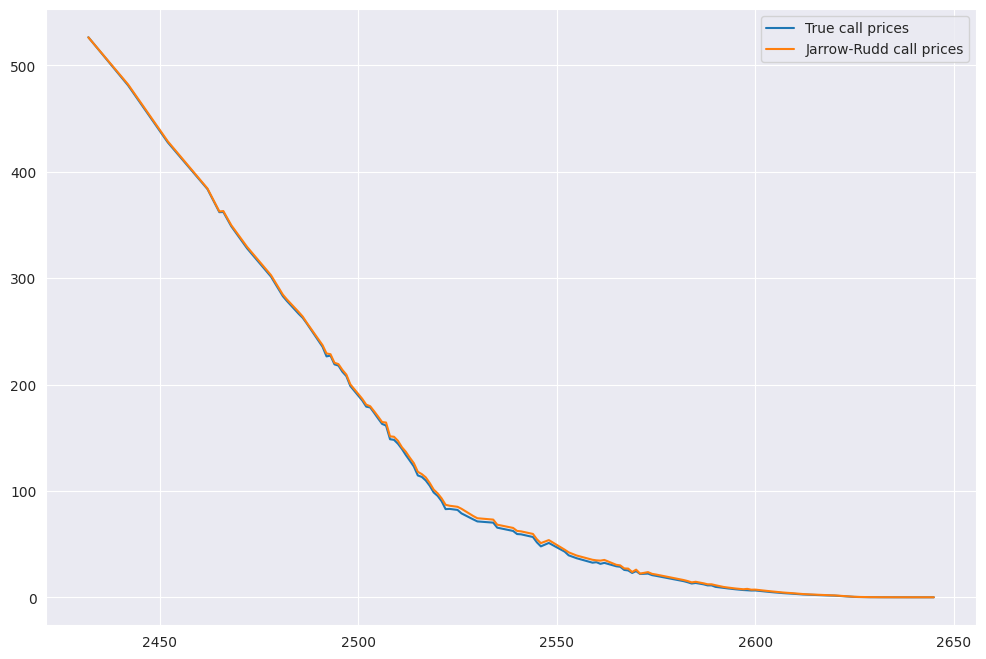

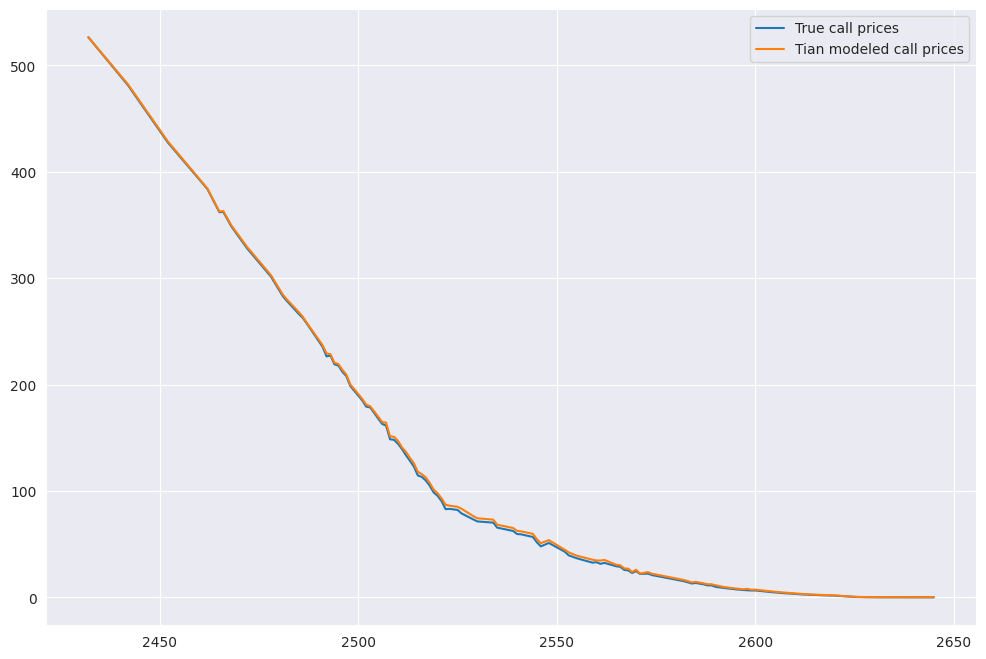

In [29]:
get_options_run_model(ticker_name="SPY", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-12-19', model="CRR", option_type="call")
get_options_run_model(ticker_name="SPY", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-12-19', model="JR", option_type="call")
get_options_run_model(ticker_name="SPY", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-12-19', model="Tian", option_type="call")

/tmp/ipykernel_3534/3795039034.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3534/3795039034.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_3534/3795039034.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_name, start=start, end=end, interval=interval)
[*********************100%***********************]  1 of 1 completed


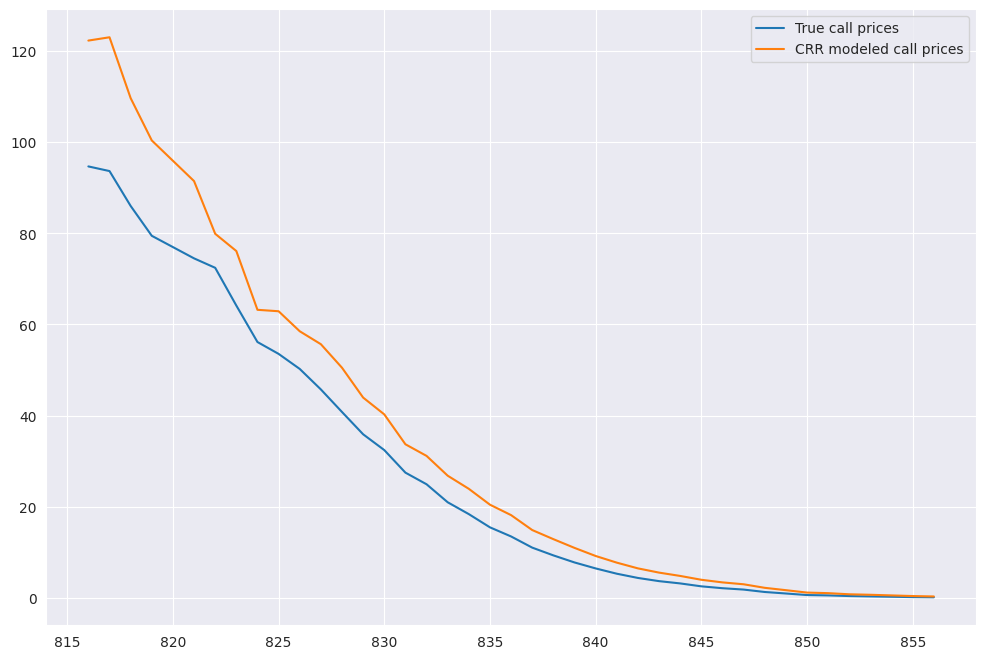

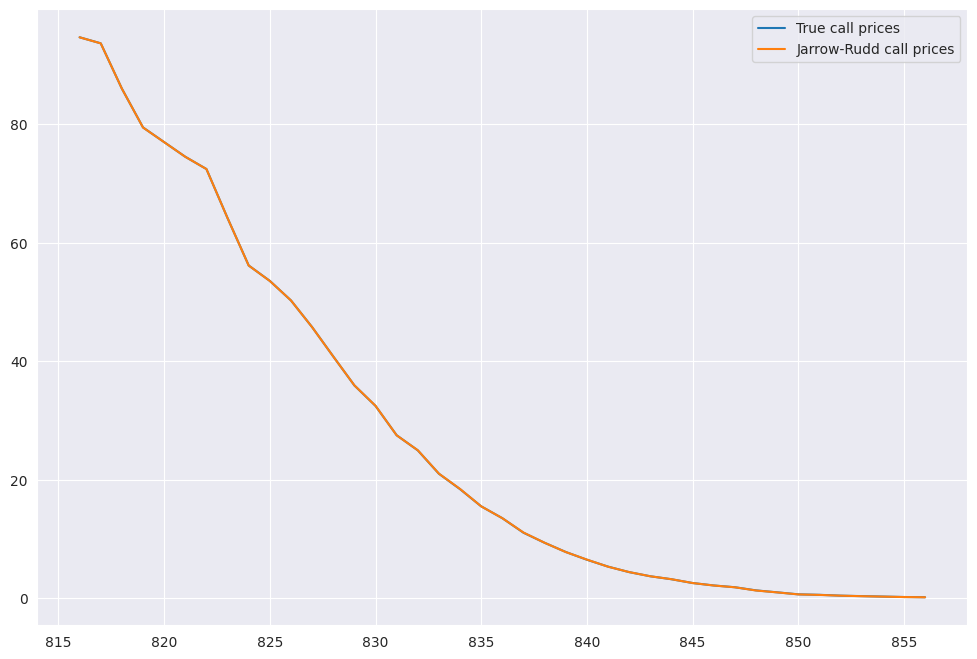

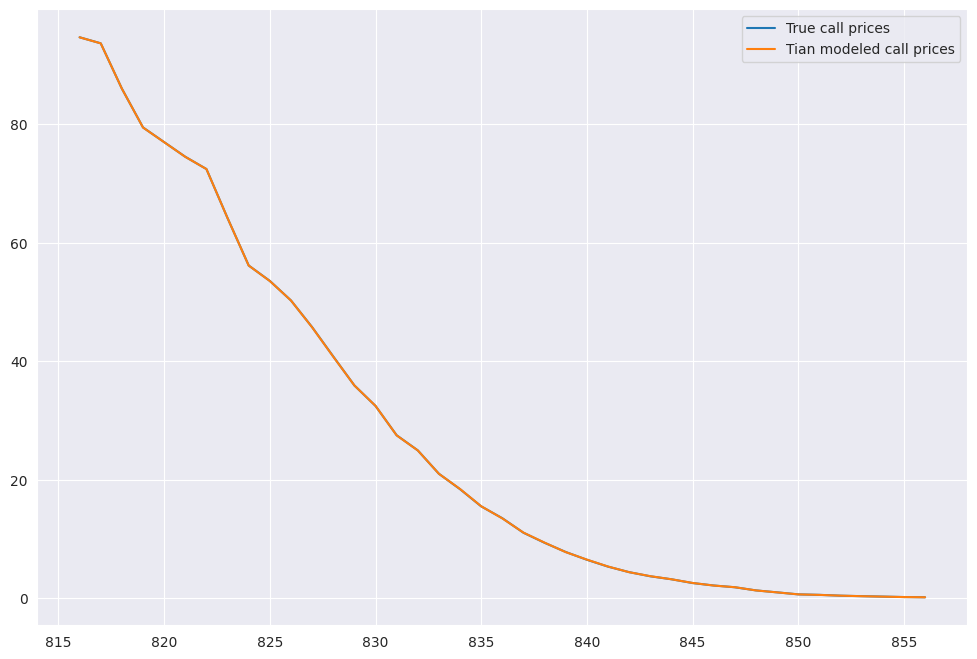

In [18]:
get_options_run_model(ticker_name="HOOD", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-12-19', model="CRR", option_type="call")
get_options_run_model(ticker_name="HOOD", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-12-19', model="JR", option_type="call")
get_options_run_model(ticker_name="HOOD", start='2025-11-01', end='2025-11-06', interval='1m', r=0.03, expiration_date='2025-12-19', model="Tian", option_type="call")

Essentially, these simulations show us the exact method that the data provider (Yahoo in our case) uses to price the options. Notice that the precision of the CRR method falls a bit behind compared to the JR or Tian binomial tree methods.